In [1]:
pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 85.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
from underthesea import word_tokenize
from gensim.models import KeyedVectors
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

2025-05-18 12:52:56.690636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747572776.885031      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747572776.942339      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# 1. Đọc và xử lý dữ liệu
data = pd.read_csv('/kaggle/input/hung-data-luat/augmented_only_dataset.csv')

data

,Câu hỏi tăng cường,Câu trả lời tăng cường
0,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật lệ trật_tự an_toàn gi...
1,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
2,công_an xe_máy giấy 01012025 phạt giao_thông t...,lái_xe giấy giấy_tờ tham_gia 4 phù_hợp tham_gi...
3,01012025 giấy hẹn tham_gia giấy đăng_ký xe_máy...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
4,giấy đăng_ký xe_máy tham_gia giao_thông xử phạ...,căn_cứ khoản 2 17 nghị_định 100 2019 nđcp bổ_s...
...,...,...
52767,bồi_thường thiệt_hại hành_khách đi máy_bay thi...,căn_cứ 162 luật hàng_không dân_dụng việt_nam 2...
52768,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52769,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52770,giải_thích chi_tiết . thế_chấp vui_lòng tàu_biển,2015 a_nghĩa_vụ thế_chấp có_thể việt_nam quyền...


In [4]:
data.rename(columns={"Câu hỏi tăng cường": "question", "Câu trả lời tăng cường": "answer"}, inplace=True)

In [5]:
data

,question,answer
0,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật lệ trật_tự an_toàn gi...
1,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
2,công_an xe_máy giấy 01012025 phạt giao_thông t...,lái_xe giấy giấy_tờ tham_gia 4 phù_hợp tham_gi...
3,01012025 giấy hẹn tham_gia giấy đăng_ký xe_máy...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
4,giấy đăng_ký xe_máy tham_gia giao_thông xử phạ...,căn_cứ khoản 2 17 nghị_định 100 2019 nđcp bổ_s...
...,...,...
52767,bồi_thường thiệt_hại hành_khách đi máy_bay thi...,căn_cứ 162 luật hàng_không dân_dụng việt_nam 2...
52768,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52769,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52770,giải_thích chi_tiết . thế_chấp vui_lòng tàu_biển,2015 a_nghĩa_vụ thế_chấp có_thể việt_nam quyền...


In [6]:
questions = data['question'].tolist()
answers = data['answer'].tolist()

In [7]:
# Chuẩn hóa dữ liệu: sửa lỗi từ ghép (thay dấu gạch dưới bằng khoảng cách)
questions = [q.replace('_', ' ') for q in questions]
answers = [a.replace('_', ' ') for a in answers]

In [8]:
# Phân tích độ dài chuỗi để chọn max_length
question_lengths = [len(q.split()) for q in questions]
answer_lengths = [len(a.split()) for a in answers]
max_length = int(max(np.percentile(question_lengths, 98), np.percentile(answer_lengths, 98)))
print(f"Max length được chọn: {max_length}")

Max length được chọn: 27


In [9]:
# Token hóa văn bản bằng underthesea
questions = [word_tokenize(q, format='text') for q in questions]
answers = [word_tokenize(a, format='text') for a in answers]

# Thêm token <start> và <end>
questions = ['<start> ' + q + ' <end>' for q in questions]
answers = ['<start> ' + a + ' <end>' for a in answers]

In [10]:
# 2. Chia dữ liệu
train_questions, temp_questions, train_answers, temp_answers = train_test_split(
    questions, answers, test_size=0.2, random_state=42
)
val_questions, test_questions, val_answers, test_answers = train_test_split(
    temp_questions, temp_answers, test_size=0.5, random_state=42
)

print(f"Kích thước tập train: {len(train_questions)}")
print(f"Kích thước tập validation: {len(val_questions)}")
print(f"Kích thước tập test: {len(test_questions)}")

Kích thước tập train: 42217
Kích thước tập validation: 5277
Kích thước tập test: 5278


In [11]:
# 3. Token hóa
tokenizer = Tokenizer(filters='', oov_token='<OOV>')  # Bỏ giới hạn num_words
tokenizer.fit_on_texts(train_questions + train_answers)
vocab_size = len(tokenizer.word_index) + 1
print(f"Kích thước từ vựng: {vocab_size}")

# Kiểm tra token <start> và <end>
print('<start>' in tokenizer.word_index, '<end>' in tokenizer.word_index)

Kích thước từ vựng: 13972
True True


In [12]:
# 4. Tạo ma trận embedding từ Word2Vec
word2vec_path = '/kaggle/input/hung-data-luat/baomoi.model_400.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 400

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)

# Kiểm tra số từ không có trong Word2Vec
missing_words = [word for word in tokenizer.word_index if word not in word2vec_model]
print(f"Số từ không có trong Word2Vec: {len(missing_words)}")

Số từ không có trong Word2Vec: 8265


In [13]:
# 5. Chuyển văn bản thành chuỗi số
train_question_sequences = tokenizer.texts_to_sequences(train_questions)
train_answer_sequences = tokenizer.texts_to_sequences(train_answers)
val_question_sequences = tokenizer.texts_to_sequences(val_questions)
val_answer_sequences = tokenizer.texts_to_sequences(val_answers)
test_question_sequences = tokenizer.texts_to_sequences(test_questions)
test_answer_sequences = tokenizer.texts_to_sequences(test_answers)

# Đệm chuỗi
train_question_padded = pad_sequences(train_question_sequences, maxlen=max_length, padding='post')
train_answer_padded = pad_sequences(train_answer_sequences, maxlen=max_length, padding='post')
val_question_padded = pad_sequences(val_question_sequences, maxlen=max_length, padding='post')
val_answer_padded = pad_sequences(val_answer_sequences, maxlen=max_length, padding='post')
test_question_padded = pad_sequences(test_question_sequences, maxlen=max_length, padding='post')
test_answer_padded = pad_sequences(test_answer_sequences, maxlen=max_length, padding='post')

train_decoder_input = pad_sequences(train_answer_padded[:, :-1], maxlen=max_length, padding='post')
val_decoder_input = pad_sequences(val_answer_padded[:, :-1], maxlen=max_length, padding='post')
train_target = pad_sequences(train_answer_padded[:, 1:], maxlen=max_length, padding='post')
val_target = pad_sequences(val_answer_padded[:, 1:], maxlen=max_length, padding='post')

In [16]:
# 6. Xây dựng mô hình
lstm_units = 256
encoder_inputs = Input(shape=(max_length,))
encoder_embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, kernel_regularizer=l2(0.01), dropout=0.3)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

decoder_inputs = Input(shape=(max_length,))
decoder_embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, kernel_regularizer=l2(0.01), dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.0005), 
             loss=SparseCategoricalCrossentropy(), 
             metrics=['accuracy'])

In [17]:
# 7. Huấn luyện mô hình và lưu lịch sử
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [train_question_padded, train_decoder_input], train_target,
    validation_data=([val_question_padded, val_decoder_input], val_target),
    epochs=30, batch_size=64, callbacks=[early_stopping]
)

Epoch 1/30


I0000 00:00:1747574095.194371      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


660/660 ━━━━━━━━━━━━━━━━━━━━ 48s 63ms/step - accuracy: 0.4110 - loss: 6.9256 - val_accuracy: 0.5297 - val_loss: 3.1341
Epoch 2/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5379 - loss: 3.0533 - val_accuracy: 0.5598 - val_loss: 2.8592
Epoch 3/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5643 - loss: 2.7929 - val_accuracy: 0.5764 - val_loss: 2.6824
Epoch 4/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5805 - loss: 2.6171 - val_accuracy: 0.5891 - val_loss: 2.5432
Epoch 5/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.5937 - loss: 2.4717 - val_accuracy: 0.5998 - val_loss: 2.4472
Epoch 6/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6031 - loss: 2.3710 - val_accuracy: 0.6071 - val_loss: 2.3708
Epoch 7/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6106 - loss: 2.2937 - val_accuracy: 0.6141 - val_loss: 2.3131
Epoch 8/30
660/660 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.6172 - loss: 2.2220 - val_accurac

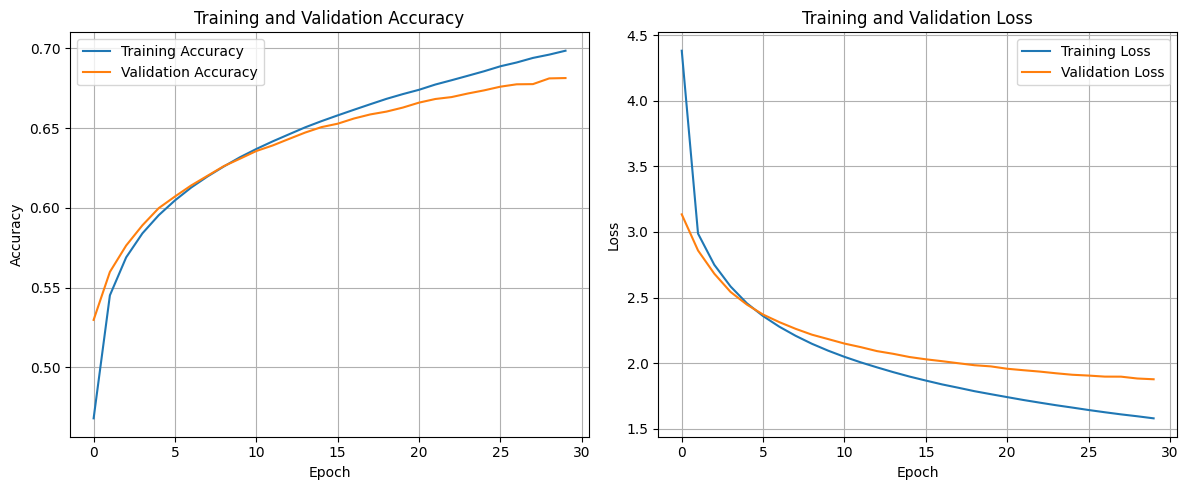

In [18]:
# 8. Hiển thị biểu đồ accuracy và loss
plt.figure(figsize=(12, 5))

# Biểu đồ accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#1f77b4')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Biểu đồ loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# 9. Mô hình suy luận
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_encoder_outputs = Input(shape=(max_length, lstm_units))
decoder_inputs_single = Input(shape=(1,))
decoder_embedding_inf = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True)(decoder_inputs_single)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedding_inf, initial_state=[decoder_state_input_h, decoder_state_input_c])
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model = Model(
    [decoder_inputs_single, decoder_state_input_h, decoder_state_input_c, decoder_encoder_outputs],
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)

In [21]:
# 10. Hàm beam search cải tiến
def beam_search_decode(input_seq, beam_width=10, max_len=30):
    encoder_outputs, h, c = encoder_model.predict(input_seq, verbose=0)
    sequences = [[[], 0.0, [h, c]]]
    for _ in range(max_len):
        all_candidates = []
        for seq, score, states in sequences:
            if seq and seq[-1] == tokenizer.word_index.get('<end>', 0):
                all_candidates.append([seq, score, states])
                continue
            target_seq = np.array([[seq[-1] if seq else tokenizer.word_index.get('<start>', 0)]])
            output_tokens, h_new, c_new = decoder_model.predict(
                [target_seq, states[0], states[1], encoder_outputs], verbose=0
            )
            top_tokens = np.argsort(output_tokens[0, -1, :])[-beam_width:][::-1]
            for token in top_tokens:
                new_score = score + np.log(output_tokens[0, -1, token] + 1e-10)
                new_seq = seq + [token]
                all_candidates.append([new_seq, new_score, [h_new, c_new]])
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        if sequences[0][0][-1] == tokenizer.word_index.get('<end>', 0):
            break
    best_seq = sequences[0][0]
    return ' '.join([tokenizer.index_word.get(idx, '<OOV>') for idx in best_seq if idx != 0])

In [22]:
# 11. Hàm gỡ lỗi dự đoán
def debug_decode(input_seq, beam_width=5, max_len=10):
    encoder_outputs, h, c = encoder_model.predict(input_seq, verbose=0)
    seq = [tokenizer.word_index.get('<start>', 0)]
    states = [h, c]
    for i in range(max_len):
        target_seq = np.array([seq[-1]])
        output_tokens, h_new, c_new = decoder_model.predict([target_seq, states[0], states[1], encoder_outputs], verbose=0)
        top_tokens = np.argsort(output_tokens[0, -1, :])[-beam_width:][::-1]
        print(f"Bước {i}:")
        for token in top_tokens:
            print(f"Token: {tokenizer.index_word.get(token, '<OOV>')}, Xác suất: {output_tokens[0, -1, token]:.4f}")
        top_token = top_tokens[0]
        seq.append(top_token)
        states = [h_new, c_new]
        if top_token == tokenizer.word_index.get('<end>', 0):
            break
    print(f"Chuỗi dự đoán: {' '.join([tokenizer.index_word.get(idx, '<OOV>') for idx in seq if idx != 0])}")

In [27]:
# 12. Hàm đánh giá
def evaluate_model(n_samples=1000):
    def get_sentence_embedding(sentence, tokenizer, embedding_matrix):
        tokens = sentence.split()
        indices = [tokenizer.word_index.get(token, 0) for token in tokens if token in tokenizer.word_index]
        if not indices:
            return np.zeros(embedding_matrix.shape[1])
        embeddings = [embedding_matrix[idx] for idx in indices if idx < embedding_matrix.shape[0]]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(embedding_matrix.shape[1])

    bleu_scores = []
    cosine_similarities = []
    for i in range(min(n_samples, len(test_questions))):
        input_seq = test_question_padded[i:i+1]
        question = test_questions[i]
        true_answer = test_answers[i]
        predicted_answer = beam_search_decode(input_seq, beam_width=10, max_len=max_length)
        bleu_score = sentence_bleu([true_answer.split()], predicted_answer.split(), smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu_score)
        true_embedding = get_sentence_embedding(true_answer, tokenizer, embedding_matrix)
        pred_embedding = get_sentence_embedding(predicted_answer, tokenizer, embedding_matrix)
        cosine_sim = cosine_similarity([true_embedding], [pred_embedding])[0][0] if np.any(true_embedding) and np.any(pred_embedding) else 0.0
        cosine_similarities.append(cosine_sim)
        print(f"Mẫu {i+1}:")
        print(f"Câu hỏi: {question}")
        print(f"Câu trả lời đúng: {true_answer}")
        print(f"Dự đoán: {predicted_answer}")
        print(f"BLEU score: {bleu_score:.4f}")
        print(f"Cosine similarity: {cosine_sim:.4f}")
        print("-" * 50)
    print(f"BLEU trung bình: {np.mean(bleu_scores):.4f}")
    print(f"Cosine similarity trung bình: {np.mean(cosine_similarities):.4f}")

# Chạy đánh giá
evaluate_model()

Mẫu 1:
Câu hỏi: <start> cá_nhân vi_phạm vi_phạm cố_tình quyết_định xử_phạt giao_thông xử_lý như_thế_nào <end>
Câu trả lời đúng: <start> căn_cứ 70 luật xử_lý vi_phạm hành_chính 2012 quy_định quyết_định xử_phạt 70 vi_phạm hành_chính giao ... <end>
Dự đoán: căn_cứ 76 luật xử_lý vi_phạm hành_chính 2012 quy_định xử_phạt vi_phạm hành_chính lập biên_bản ... ... ... ... ... ... ... ... ... ... ... ... ... ...
BLEU score: 0.2082
Cosine similarity: 0.8514
--------------------------------------------------
Mẫu 2:
Câu hỏi: <start> công_trình bảo_trì hàng_hải vui_lòng chi_phí . chi_tiết giải_thích <end>
Câu trả lời đúng: <start> . 1 chi_phí hàng_hải bảo_trì công_trình . bảo_trì 6 nghị_định xây_dựng kinh_phí tương_ứng thực_hiện ... <end>
Dự đoán: căn_cứ khoản 1 4 thông_tư 192022 ttbgtvt hiệu_lực 01102022 quy_định chi_phí bảo_trì công_trình ... ... ... ... ... ... ... ... ... ... ... ... ... ...
BLEU score: 0.0186
Cosine similarity: 0.6075
--------------------------------------------------
Mẫu 3:
Câu